In [1]:
## Imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# import warnings 
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
energy = pd.read_csv('./data/volume.csv')
energy.head()

,time,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682
0,2022-09-01 00:00:00,0.0000,1.1667,0.5833,0.0000,6.6108,3.5000,3.2141,1.1667,0.0,...,5.2500,15.0,0.0,2.9167,2.3333,0.5833,1.7500,0.5833,1.1667,0.0
1,2022-09-01 01:00:00,0.0000,1.1667,0.5833,0.0000,9.1765,4.0833,3.6216,1.1667,572.5,...,5.2500,15.0,0.0,3.5000,2.9167,0.5833,1.7500,0.5833,1.1667,0.0
2,2022-09-01 02:00:00,0.5833,0.0000,0.0000,6.7500,7.8682,4.6667,3.7150,2.3333,722.5,...,9.9167,7.5,0.0,2.9167,4.6667,1.1667,2.9167,0.5833,0.0000,0.0
3,2022-09-01 03:00:00,0.5833,0.0000,0.0000,6.7500,9.3332,4.6667,3.7248,2.3333,697.5,...,9.9167,7.5,0.0,2.9167,4.6667,0.5833,2.9167,0.5833,0.0000,0.0
4,2022-09-01 04:00:00,0.0000,1.1667,0.5833,5.5833,11.5353,4.0833,3.7273,1.1667,660.0,...,5.2500,15.0,0.0,2.9167,2.9167,0.0000,1.7500,0.5833,0.5833,0.0


In [3]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Columns: 1683 entries, time to 2682
dtypes: float64(1682), object(1)
memory usage: 112.5+ MB


## Data Dictionary

The 'energy' dataframe is the total energy in kWh (kiloWatt hour) per each hour of charging. This will be the predicted y variable.

| Variable | Description | Details |
|----------|-------------|---------|
| time | Time | Year-Month-Day Hour:Minute:Seconds |
| 1001-2682 | Station IDs | Charging Station IDs from 1001 to 2682. |


In [7]:
energy.describe().round(2) # e.g. max energy for 1004 is 459 kWh. 

,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,...,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682
count,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,...,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00,8760.00
mean,0.41,0.51,0.05,8.97,11.48,2.15,2.03,1.19,312.12,152.56,...,4.72,3.51,1.26,0.88,0.86,0.43,0.51,0.05,0.38,0.45
std,1.18,0.65,0.25,11.67,7.99,1.86,1.42,1.51,152.73,189.40,...,2.36,5.88,5.65,1.37,1.44,0.51,0.97,0.22,0.52,1.38
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,5.51,7.88,0.65,0.84,0.00,198.75,0.00,...,2.92,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.22,0.00,8.14,10.60,1.75,1.75,1.11,275.00,0.00,...,4.67,0.00,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00
75%,0.58,0.98,0.00,11.75,13.79,3.44,3.17,1.75,425.00,286.25,...,6.42,7.50,0.00,1.75,1.17,0.58,0.58,0.00,0.58,0.00
max,34.97,11.74,7.62,459.42,249.70,51.09,5.96,31.02,1972.12,772.50,...,13.42,30.00,60.00,5.25,6.42,2.92,5.25,2.33,2.92,16.17


In [8]:
# Zeroes: Assume '0' means that the station is idle with no car currently charging, as we cannot validate this manually from the station's backup data.
num_zeros = (energy == 0).sum().sum()
(num_zeros/(energy.size))*100 # The stations are 40% idle, which is a significant portion of the training data. 

40.14731657157121

In [9]:
# The workaround is to use time slots e.g. 24 hours / n slots. 1hr n=24, 2hr n=12, 3hr n=8, 4hr slots n=6. 
# The variance should be different for each slot and we choose the 'active' slots with minimum variance to continue with model prediction.

In [98]:
energy.min() # minimum energy consumption is 0kwh. 

time    2022-09-01 00:00:00
1001                    0.0
1002                    0.0
1003                    0.0
1004                    0.0
               ...         
2678                    0.0
2679                    0.0
2680                    0.0
2681                    0.0
2682                    0.0
Length: 1683, dtype: object

In [104]:
energy.max()

time    2023-08-31 23:00:00
1001                 34.971
1002                11.7383
1003                 7.6233
1004               459.4208
               ...         
2678                 2.9167
2679                   5.25
2680                 2.3333
2681                 2.9167
2682                16.1667
Length: 1683, dtype: object

In [110]:
np.max(energy.iloc[:, 1:]) # max. energy consumption is 31476 kwh. 

31476.0645

In [126]:
energy.loc[energy.isin([31476.0645]).any(axis=1)] #which station had the maximum energy (occurred at 13:00h 2023 march 1st).

,time,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682
4357,2023-03-01 13:00:00,0.0,0.0,0.0,0.0,18.5,1.75,0.0,0.0,261.25,...,1.1667,0.0,0.0,0.0,0.0,1.1667,0.0,0.0,0.0,0.0


In [130]:
energy.columns[(energy == 31476.0645).any()].tolist() # station 1251 had the highest energy 

['1251']

In [10]:
energy['time'].dtype #object type

dtype('O')

In [11]:
## Choosing the first station at random, station 1001, the total energy per hour for the period spanning from Sept 01 2022 to Aug 31 2023 is: 

In [12]:
energy_st1 = energy[['time', '1001']] #station 1001
energy_st1

,time,1001
0,2022-09-01 00:00:00,0.0000
1,2022-09-01 01:00:00,0.0000
2,2022-09-01 02:00:00,0.5833
3,2022-09-01 03:00:00,0.5833
4,2022-09-01 04:00:00,0.0000
...,...,...
8755,2023-08-31 19:00:00,0.6748
8756,2023-08-31 20:00:00,0.6546
8757,2023-08-31 21:00:00,0.6397
8758,2023-08-31 22:00:00,0.7098


In [13]:
energy[energy['time'] == '2022-09-12 06:00:00']

,time,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682
270,2022-09-12 06:00:00,1.1667,0.0,0.5833,17.9167,15.8755,3.5,3.9703,0.5833,647.5,...,7.0,0.0,0.0,2.9167,4.0833,0.0,3.5,1.1667,0.0,0.0


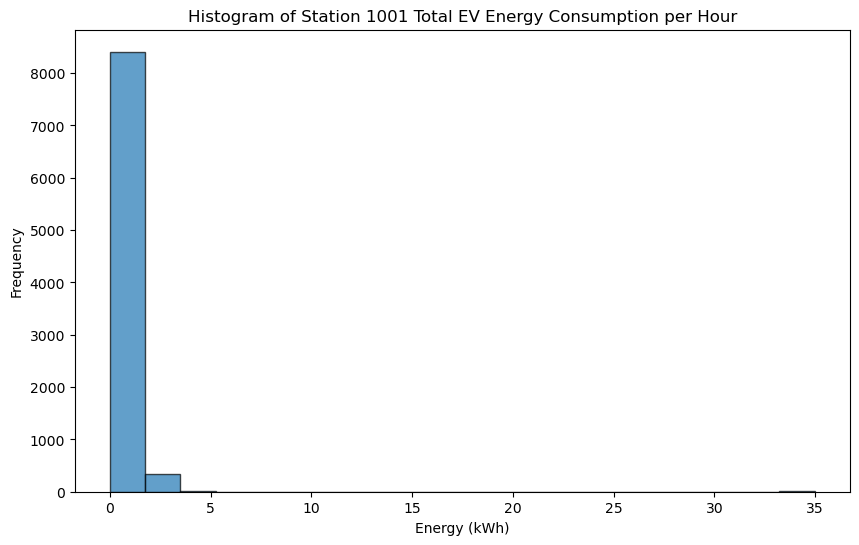

In [14]:
# histogram
plt.figure(figsize=(10, 6)) 
plt.hist(energy['1001'], bins=20, edgecolor='black', alpha=0.7) 
plt.xlabel('Energy (kWh)') 
plt.ylabel('Frequency') 
plt.title('Histogram of Station 1001 Total EV Energy Consumption per Hour')
plt.show() 
#station 1001 shows most of the EVs (>8000 cars) uses energy below 5kWh with some at peak demands at 35kwh. 1kWh is like a dishwasher of 1000kW running for an hour. 
# Hence, this station has low energy consumption as most of the data is located on the left (the histogram is right-skewed).

In [15]:
energy_st1.shape

(8760, 2)

In [16]:
# Convert date column to datetime format
energy_st1['time'] = pd.to_datetime(energy['time'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)

# Set date as index for time series analysis
energy_st1.set_index('time').sort_index()                              
                                    
# Display first few rows
energy_st1.head()

C:\Users\Nareerat Moottatarn\AppData\Local\Temp\ipykernel_22372\2428716122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_st1['time'] = pd.to_datetime(energy['time'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)


,time,1001
0,2022-09-01 00:00:00,0.0000
1,2022-09-01 01:00:00,0.0000
2,2022-09-01 02:00:00,0.5833
3,2022-09-01 03:00:00,0.5833
4,2022-09-01 04:00:00,0.0000


In [74]:
# same output with no warning:
energy_st1 = (energy_st1
              .set_index(pd.DatetimeIndex(energy_st1['time']))
              .drop('time', axis=1)
              .sort_index())

energy_st1.head()

,1001
time,
2022-09-01 00:00:00,0.0000
2022-09-01 01:00:00,0.0000
2022-09-01 02:00:00,0.5833
2022-09-01 03:00:00,0.5833
2022-09-01 04:00:00,0.0000


In [17]:
# Choosing another station at random, station 1009.

In [18]:
energy_st9 = energy[['time', '1009']]
energy_st9

,time,1009
0,2022-09-01 00:00:00,0.0000
1,2022-09-01 01:00:00,572.5000
2,2022-09-01 02:00:00,722.5000
3,2022-09-01 03:00:00,697.5000
4,2022-09-01 04:00:00,660.0000
...,...,...
8755,2023-08-31 19:00:00,251.1988
8756,2023-08-31 20:00:00,185.9804
8757,2023-08-31 21:00:00,180.0873
8758,2023-08-31 22:00:00,187.6248


In [19]:
energy_st9['1009'].nunique()

4145

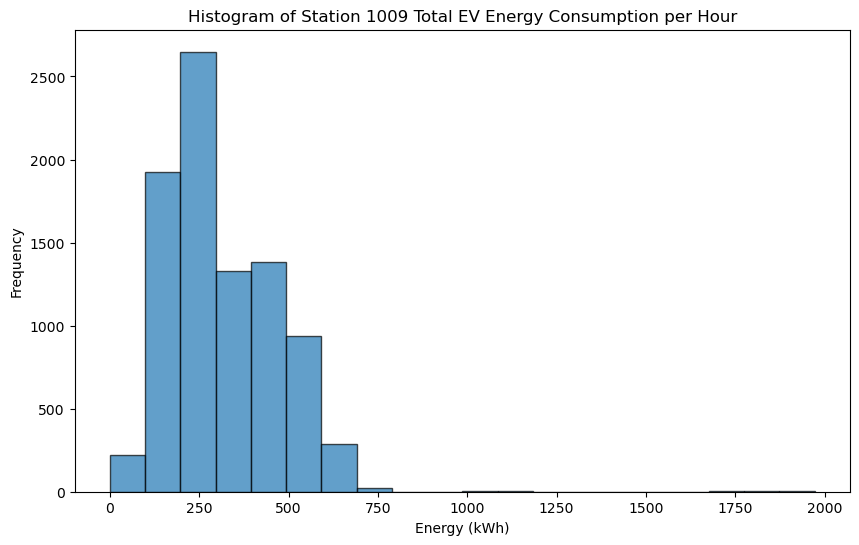

In [20]:
# Create a histogram 
plt.figure(figsize=(10, 6)) 
plt.hist(energy['1009'], bins=20, edgecolor='black', alpha=0.7) 
plt.xlabel('Energy (kWh)') 
plt.ylabel('Frequency') 
plt.title('Histogram of Station 1009 Total EV Energy Consumption per Hour')
plt.show()
#In contrast, station 1009 shows a more normal distribution of traffic and energy use (mode energy is 250kWh), few high demand at 2000 kWh. 
# However, the traffic is less (freq. 2500 cars in the year).

In [21]:
#Thus, choosing 1009 I will predict the next 1hr, 2hr, 3hr, and 4hr time frame using forecasts from previous historical data.

In [22]:
energy.head()

,time,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,2673,2674,2675,2676,2677,2678,2679,2680,2681,2682
0,2022-09-01 00:00:00,0.0000,1.1667,0.5833,0.0000,6.6108,3.5000,3.2141,1.1667,0.0,...,5.2500,15.0,0.0,2.9167,2.3333,0.5833,1.7500,0.5833,1.1667,0.0
1,2022-09-01 01:00:00,0.0000,1.1667,0.5833,0.0000,9.1765,4.0833,3.6216,1.1667,572.5,...,5.2500,15.0,0.0,3.5000,2.9167,0.5833,1.7500,0.5833,1.1667,0.0
2,2022-09-01 02:00:00,0.5833,0.0000,0.0000,6.7500,7.8682,4.6667,3.7150,2.3333,722.5,...,9.9167,7.5,0.0,2.9167,4.6667,1.1667,2.9167,0.5833,0.0000,0.0
3,2022-09-01 03:00:00,0.5833,0.0000,0.0000,6.7500,9.3332,4.6667,3.7248,2.3333,697.5,...,9.9167,7.5,0.0,2.9167,4.6667,0.5833,2.9167,0.5833,0.0000,0.0
4,2022-09-01 04:00:00,0.0000,1.1667,0.5833,5.5833,11.5353,4.0833,3.7273,1.1667,660.0,...,5.2500,15.0,0.0,2.9167,2.9167,0.0000,1.7500,0.5833,0.5833,0.0


In [23]:
# Note: lat long for Station 1009 : 22.716747, 113.794798

In [44]:
# Convert date column to datetime format
energy_st9['time'] = pd.to_datetime(energy['time'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)

# Set date as index for time series analysis
energy_st9 = energy_st9.set_index('time').sort_index()                              
                                    
# Display first few rows
energy_st9.head()

C:\Users\Nareerat Moottatarn\AppData\Local\Temp\ipykernel_22372\1582559387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_st9['time'] = pd.to_datetime(energy['time'], format='%Y-%m-%d %H:%M:%S', dayfirst=True)


,1009
time,
2022-09-01 00:00:00,0.0
2022-09-01 01:00:00,572.5
2022-09-01 02:00:00,722.5
2022-09-01 03:00:00,697.5
2022-09-01 04:00:00,660.0


In [46]:
energy_st9.tail()

,1009
time,
2023-08-31 19:00:00,251.1988
2023-08-31 20:00:00,185.9804
2023-08-31 21:00:00,180.0873
2023-08-31 22:00:00,187.6248
2023-08-31 23:00:00,218.5438


In [48]:
energy_st9.isnull().sum() #first row is zero kWh.

1009    0
dtype: int64

In [ ]:
# (yyyy-mm-dd)
# earliest date: 2022-09-01
# last date: 2023-08-31

In [54]:
#Resample the data into 'ME' month end
energy_st9.resample('ME').sum()

,1009
time,
2022-09-30,283993.7500
2022-10-31,269787.5000
2022-11-30,242520.6722
2022-12-31,255238.7500
2023-01-31,153205.0000
2023-02-28,211535.0000
2023-03-31,253990.5714
2023-04-30,200214.5762
2023-05-31,227845.8258


In [56]:
energy_st9.dtypes

1009    float64
dtype: object

In [58]:
type(energy_st9)

pandas.core.frame.DataFrame

In [60]:
# rolling mean 3 weeks
energy_st9['1009'].rolling(3).mean().dropna() #dropping the 2 NaN values at the beginning, as there are not enough for 3 weeks prior for the rolling mean calculation.  

time
2022-09-01 02:00:00    431.666667
2022-09-01 03:00:00    664.166667
2022-09-01 04:00:00    693.333333
2022-09-01 05:00:00    680.833333
2022-09-01 06:00:00    664.583333
                          ...    
2023-08-31 19:00:00    202.175967
2023-08-31 20:00:00    210.666100
2023-08-31 21:00:00    205.755500
2023-08-31 22:00:00    184.564167
2023-08-31 23:00:00    195.418633
Name: 1009, Length: 8758, dtype: float64

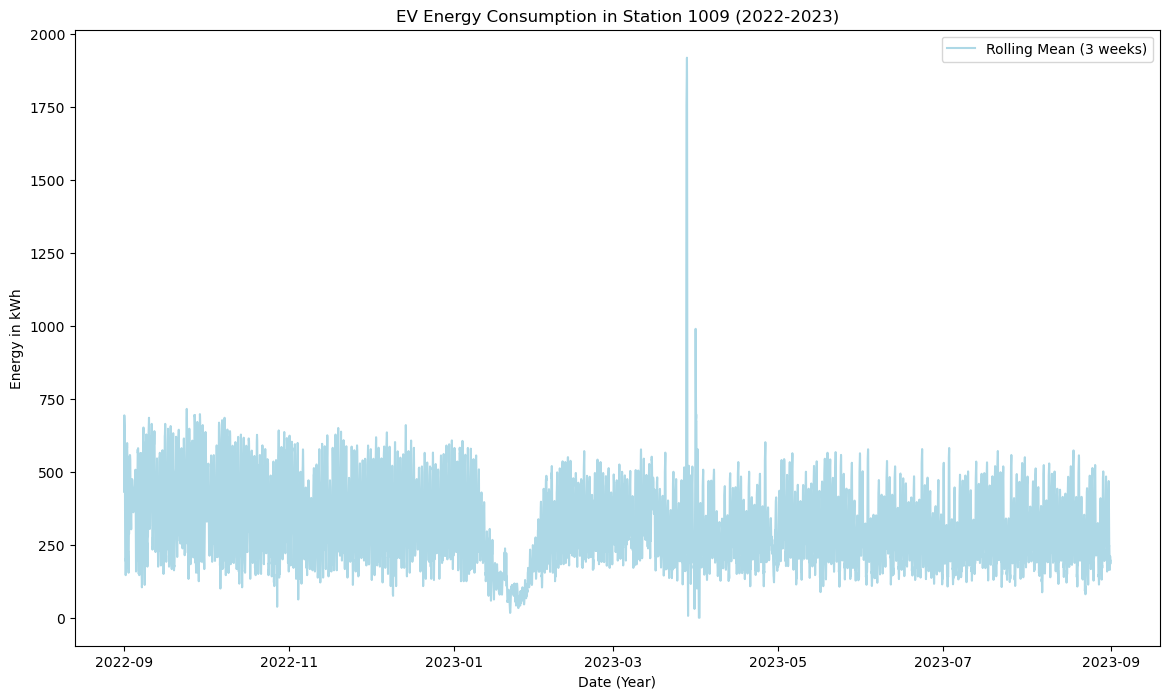

In [64]:
#plot trend MA=3 (moving average 3 weeks)

plt.figure(figsize=(14,8))
plt.plot(energy_st9['1009'].rolling(3, center=True).mean(), color='lightblue', label='Rolling Mean (3 weeks)') #center=True for timeframe to be centered
plt.title('EV Energy Consumption in Station 1009 (2022-2023)')
plt.xlabel('Date (Year)')
plt.ylabel('Energy in kWh')
plt.legend()
plt.show() #interesting dip in Jan-Feb, peak in month 3-4. 

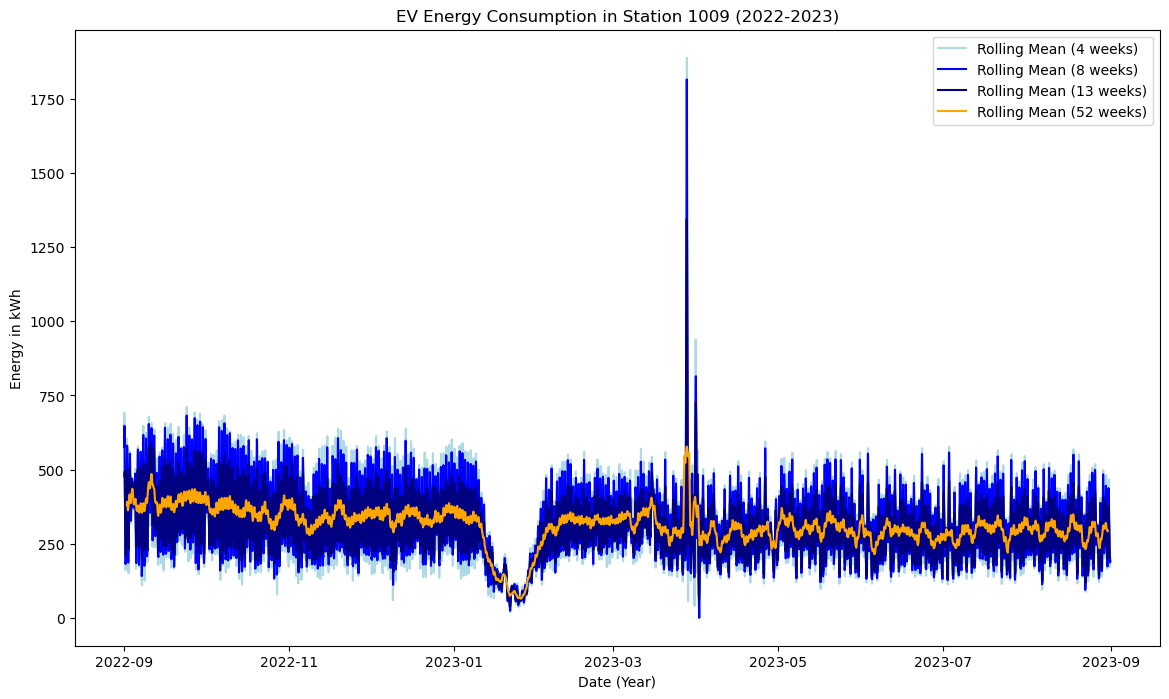

In [68]:
# Change MA = 4 weeks, 8 weeks, 13 weeks
plt.figure(figsize=(14,8))
plt.plot(energy_st9['1009'].rolling(4, center=True).mean(), color='lightblue', label='Rolling Mean (4 weeks)')
plt.plot(energy_st9['1009'].rolling(8, center=True).mean(), color='blue', label='Rolling Mean (8 weeks)')
plt.plot(energy_st9['1009'].rolling(13, center=True).mean(), color='navy', label='Rolling Mean (13 weeks)')
plt.plot(energy_st9['1009'].rolling(52, center=True).mean(), color='orange', label='Rolling Mean (52 weeks)')
plt.title('EV Energy Consumption in Station 1009 (2022-2023)')
plt.xlabel('Date (Year)')
plt.ylabel('Energy in kWh')
plt.legend()
plt.show() #appears to be cyclical, amplitudes generally similar, peak in April and drop in Jan-Feb in energy.

In [70]:
# which month had the most and least energy demand overall?
energy_st9.resample('ME').sum().sort_values(by='1009', ascending=False)

,1009
time,
2022-09-30,283993.7500
2022-10-31,269787.5000
2022-12-31,255238.7500
2023-03-31,253990.5714
2022-11-30,242520.6722
2023-05-31,227845.8258
2023-08-31,217386.9420
2023-07-31,217183.0324
2023-02-28,211535.0000


In [76]:
# Another station, try station 1380's output 
energy_st1380 = energy[['time', '1380']]

In [78]:
energy_st1380 = (energy_st1380
              .set_index(pd.DatetimeIndex(energy_st1380['time']))
              .drop('time', axis=1)
              .sort_index())

energy_st1380.head()

,1380
time,
2022-09-01 00:00:00,6.4167
2022-09-01 01:00:00,6.4167
2022-09-01 02:00:00,4.0833
2022-09-01 03:00:00,4.0833
2022-09-01 04:00:00,4.0833


In [82]:
energy_st1380.tail()

,1380
time,
2023-08-31 19:00:00,0.0
2023-08-31 20:00:00,0.0
2023-08-31 21:00:00,0.0
2023-08-31 22:00:00,0.0
2023-08-31 23:00:00,0.0


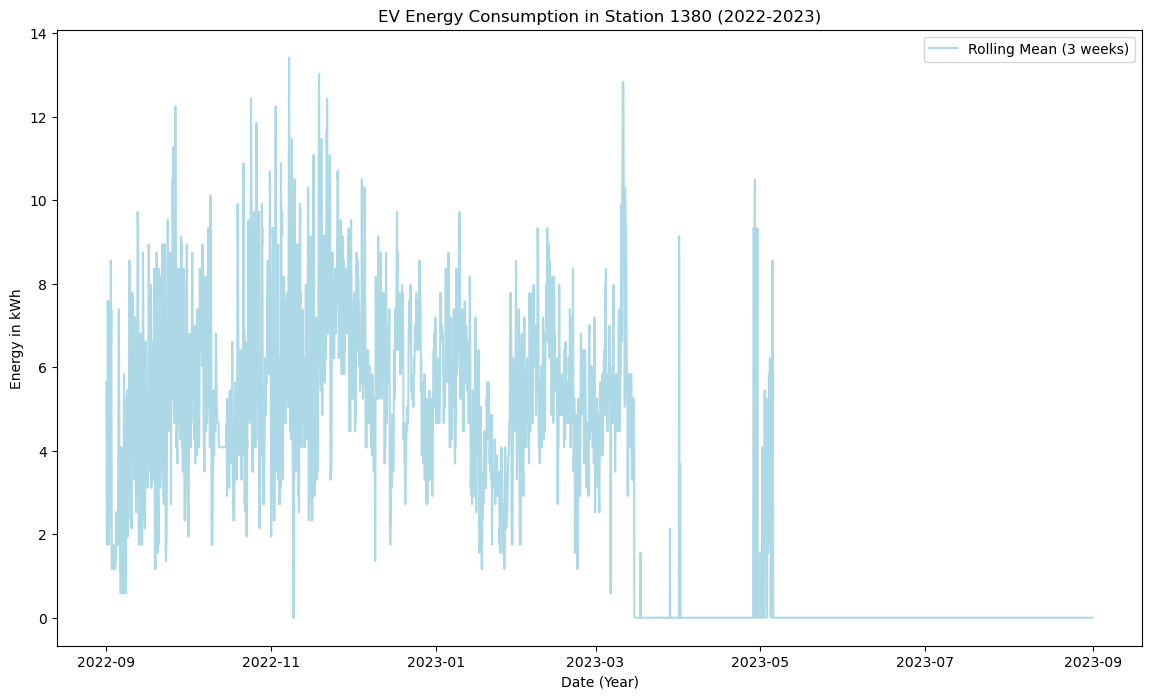

In [80]:
#plot trend MA=3 (moving average 3 weeks)

plt.figure(figsize=(14,8))
plt.plot(energy_st1380['1380'].rolling(3, center=True).mean(), color='lightblue', label='Rolling Mean (3 weeks)') #center=True for timeframe to be centered
plt.title('EV Energy Consumption in Station 1380 (2022-2023)')
plt.xlabel('Date (Year)')
plt.ylabel('Energy in kWh')
plt.legend()
plt.show() #station 1380 seems to show 0 kWh energy and no change, perhaps discontinued services or was under maintenance mode after month-05 (May) 2023.

In [86]:
#looking at another station 2667
energy_st2667 = energy[['time', '2667']]

In [88]:
energy_st2667 = (energy_st2667
              .set_index(pd.DatetimeIndex(energy_st2667['time']))
              .drop('time', axis=1)
              .sort_index())

energy_st2667.head()

,2667
time,
2022-09-01 00:00:00,20.0
2022-09-01 01:00:00,480.0
2022-09-01 02:00:00,380.0
2022-09-01 03:00:00,350.0
2022-09-01 04:00:00,170.0


In [90]:
energy_st2667.tail()

,2667
time,
2023-08-31 19:00:00,80.0
2023-08-31 20:00:00,80.0
2023-08-31 21:00:00,70.0
2023-08-31 22:00:00,20.0
2023-08-31 23:00:00,0.0


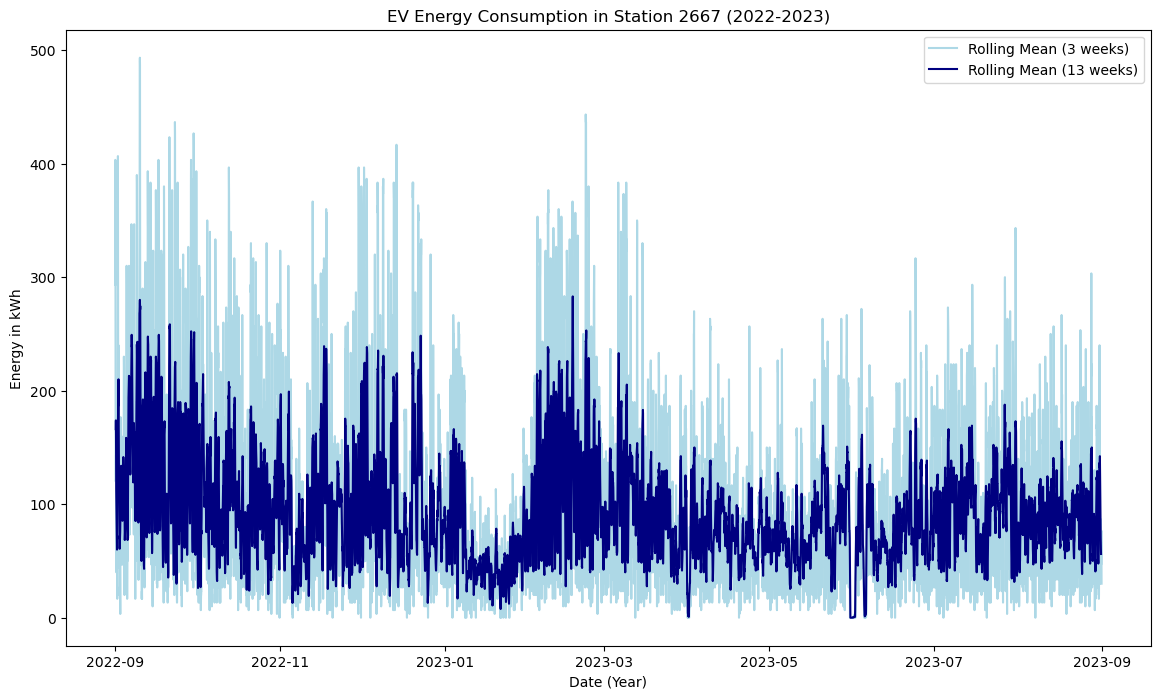

In [94]:
#plot trend MA=3 (moving average 3 weeks)

plt.figure(figsize=(14,8))
plt.plot(energy_st2667['2667'].rolling(3, center=True).mean(), color='lightblue', label='Rolling Mean (3 weeks)')
plt.plot(energy_st2667['2667'].rolling(13, center=True).mean(), color='navy', label='Rolling Mean (13 weeks)')
plt.title('EV Energy Consumption in Station 2667 (2022-2023)')
plt.xlabel('Date (Year)')
plt.ylabel('Energy in kWh')
plt.legend()
plt.show() #This station 1380 shows a less pronounced dip in Feb, one brief period of 0 kWh energy in 2023 month 6.

In [132]:
# Highest Energy station
energy_st1251 = energy[['time', '1251']] #station 1251
energy_st1251

,time,1251
0,2022-09-01 00:00:00,0.0000
1,2022-09-01 01:00:00,480.0000
2,2022-09-01 02:00:00,360.0000
3,2022-09-01 03:00:00,270.0000
4,2022-09-01 04:00:00,360.0000
...,...,...
8755,2023-08-31 19:00:00,173.7683
8756,2023-08-31 20:00:00,325.1226
8757,2023-08-31 21:00:00,361.8033
8758,2023-08-31 22:00:00,309.3133


In [134]:
energy_st1251 = (energy_st1251
              .set_index(pd.DatetimeIndex(energy_st1251['time']))
              .drop('time', axis=1)
              .sort_index())

energy_st1251.head()

,1251
time,
2022-09-01 00:00:00,0.0
2022-09-01 01:00:00,480.0
2022-09-01 02:00:00,360.0
2022-09-01 03:00:00,270.0
2022-09-01 04:00:00,360.0


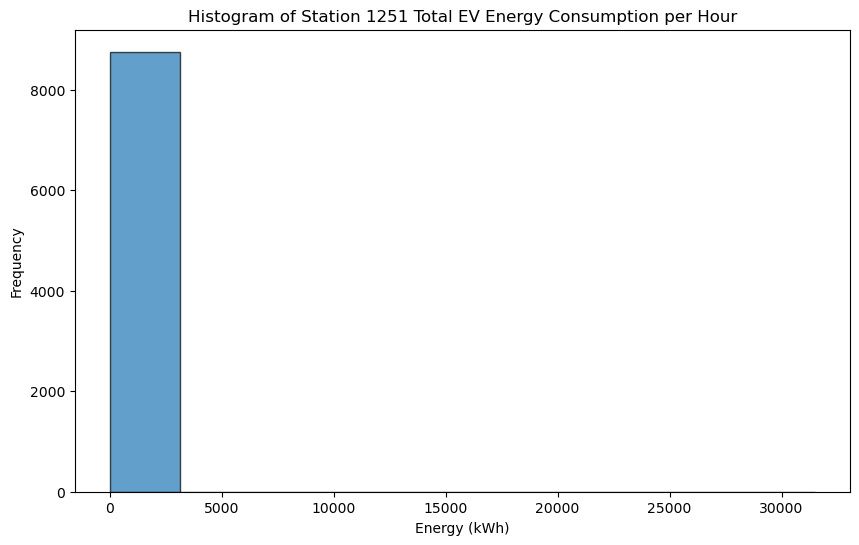

In [138]:
plt.figure(figsize=(10, 6)) 
plt.hist(energy['1251'], bins=10, edgecolor='black', alpha=0.7) 
plt.xlabel('Energy (kWh)') 
plt.ylabel('Frequency') 
plt.title('Histogram of Station 1251 Total EV Energy Consumption per Hour')
plt.show()

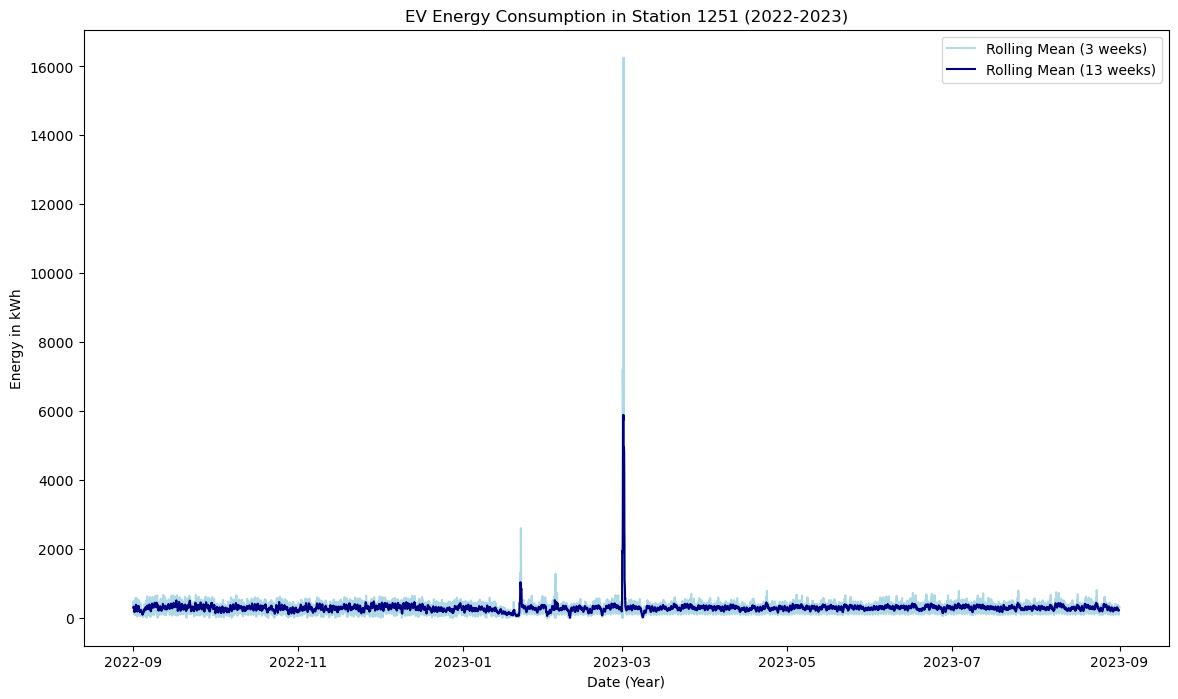

In [140]:
#plot trend MA=3 (moving average 3 weeks)

plt.figure(figsize=(14,8))
plt.plot(energy_st1251['1251'].rolling(3, center=True).mean(), color='lightblue', label='Rolling Mean (3 weeks)')
plt.plot(energy_st1251['1251'].rolling(13, center=True).mean(), color='navy', label='Rolling Mean (13 weeks)')
plt.title('EV Energy Consumption in Station 1251 (2022-2023)')
plt.xlabel('Date (Year)')
plt.ylabel('Energy in kWh')
plt.legend()
plt.show() #T

In [142]:
energy_st1251.describe() # seems to be an outlier since the value of kwh is too high

,1251
count,8760.000000
mean,285.771367
std,462.483732
min,0.000000
25%,129.768800
50%,257.926950
75%,390.000000
max,31476.064500


In [ ]:
# Thus, for analysis and modeling, I would choose a typical charging station of less than 1000 kwh without anomalies (zeros, extreme outliers), such as station 1009.

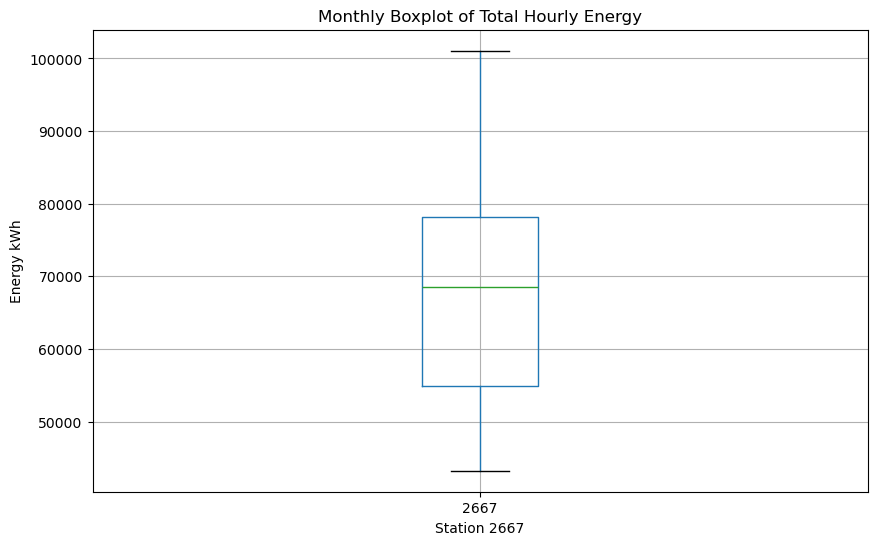

In [148]:
# Resample data by month and calculate statistics 
energy_st2667_monthly = energy_st2667.resample('ME').sum() 
# boxplot for each month 
plt.figure(figsize=(10, 6)) 
energy_st2667_monthly.boxplot() 
plt.title('Monthly Boxplot of Total Hourly Energy') 
plt.ylabel('Energy kWh') 
plt.xlabel('Station 2667')
plt.grid(True)
plt.show()

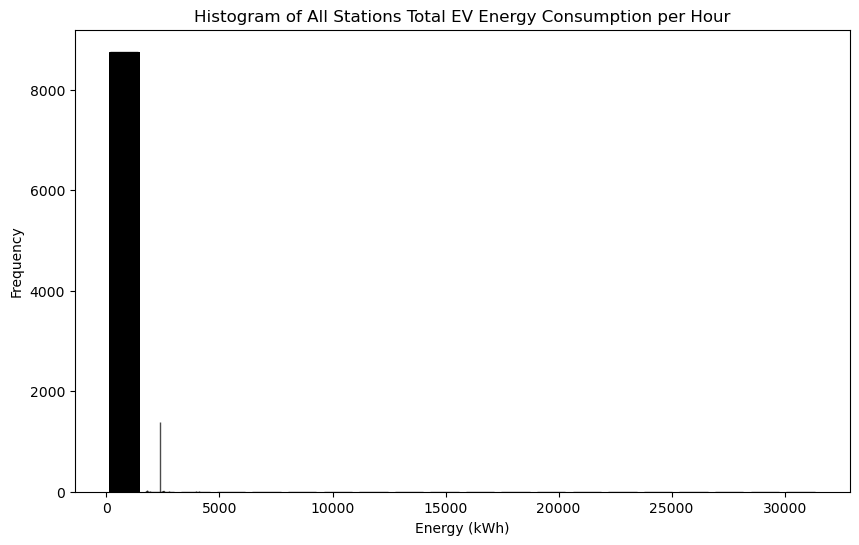

In [151]:
plt.figure(figsize=(10, 6)) 
plt.hist(energy.iloc[:, 1:], bins=20, edgecolor='black', alpha=0.7) 
plt.xlabel('Energy (kWh)') 
plt.ylabel('Frequency') 
plt.title('Histogram of All Stations Total EV Energy Consumption per Hour')
plt.show() #concluding that most stations have under approx. 2500 kWh per hour on average for typical EV charging operations.

In [ ]:
# Summary, no zeroes were dropped and no outliers were removed as the data contains important information on the charging station.